# Classificação das imagens utilizando uma CNN

## Arquitetura da Solução

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

*   Covid
*   Virus
*   Normal



Segue abaixo o código necessário para realizar download do dataset, realizar unzip e excluir arquivos desnecessários:

In [70]:
!kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
!unzip /content/covid-19-chest-x-ray.zip
!rm /content/covid-19-chest-x-ray.zip

Dataset URL: https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray
License(s): Apache 2.0
covid-19-chest-x-ray.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open /content/covid-19-chest-x-ray.zip, /content/covid-19-chest-x-ray.zip.zip or /content/covid-19-chest-x-ray.zip.ZIP.
rm: cannot remove '/content/covid-19-chest-x-ray.zip': No such file or directory


## Imports

In [71]:
# !pip install torch
# !pip install torchinfo

In [72]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import random
import torch
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split, ConcatDataset # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
from torchvision import datasets, transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from sklearn.metrics import confusion_matrix, classification_report
import torchvision
%matplotlib inline

In [73]:
# selecionar a GPU caso exista
# ao selecionar a GPU, a tendencia é que o codigo seja executado mais rapidamente
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Pré-processamento dos dados

In [76]:
# Define a transformação a ser aplicada nas imagens
# transform = pretrained_vit_w.transforms()

transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=1.0),
    transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
originalDataset = datasets.ImageFolder(root="Data/", transform=transform)
flippedDataset = datasets.ImageFolder(root="Data/", transform=transform2)

dataset = ConcatDataset([originalDataset, flippedDataset])

class_names = originalDataset.classes # [covid, normal, virus]

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.7
validation_ratio = 0.15

# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size

# Divide o dataset em conjuntos de treino e teste
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

In [77]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}

for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de validacao
validation_class_count = {}

for _, label in validation_dataset:
    if label in validation_class_count:
        validation_class_count[label] += 1
    else:
        validation_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento e teste
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento e teste
print(f'Tamanho do conjunto de validação: {len(validation_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de validação:")
for class_idx, count in validation_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")


Tamanho do conjunto de treino: 1674
Quantidade de imagens por classe no conjunto de treinamento:
Classe 1: 654 imagens
Classe 2: 603 imagens
Classe 0: 417 imagens
Tamanho do conjunto de validação: 358
Quantidade de imagens por classe no conjunto de validação:
Classe 2: 143 imagens
Classe 0: 91 imagens
Classe 1: 124 imagens

Tamanho do conjunto de teste: 360
Quantidade de imagens por classe no conjunto de teste:
Classe 0: 82 imagens
Classe 2: 120 imagens
Classe 1: 158 imagens


## Definindo nosso modelo

In [78]:
class MyCNN(nn.Module):
    def __init__(self, num_diseases):
        super().__init__()

        self.features = nn.Sequential(
            # Entrada: 3x224x224 (3 canais de cor)
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 8x112x112

            # Entrada: 8x112x112
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 16x56x56
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)), # Global Max Pooling
            nn.Flatten(),
            nn.Linear(16, num_diseases)  # Mapeia diretamente para o número de doenças
        )

    def forward(self, xb):
        xb = self.features(xb)
        xb = self.classifier(xb)
        return xb
    

model = MyCNN(len(class_names)).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [79]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MyCNN (MyCNN)                            [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 16, 56, 56]     --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 8, 224, 224]    224                  True
│    └─BatchNorm2d (1)                   [32, 8, 224, 224]    [32, 8, 224, 224]    16                   True
│    └─ReLU (2)                          [32, 8, 224, 224]    [32, 8, 224, 224]    --                   --
│    └─MaxPool2d (3)                     [32, 8, 224, 224]    [32, 8, 112, 112]    --                   --
│    └─Conv2d (4)                        [32, 8, 112, 112]    [32, 16, 112, 112]   1,168                True
│    └─BatchNorm2d (5)                   [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    └─ReLU (6)   

In [80]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        val_loss, val_acc = val_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # Return the filled results at the end of the epochs
    return results

def predict(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:

    # Put model in eval
    model.eval()

    # Create empty lists to store predictions and targets
    all_preds = []
    all_targets = []

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)
            
            all_preds.append(val_pred_logits)
            all_targets.append(y)

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return all_preds, all_targets


In [81]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(42)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
torch.cuda.manual_seed(42)
cnn_results = train(model=model,
                    train_dataloader=train_loader,
                    val_dataloader=validation_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=30,
                    device=device)

  3%|▎         | 1/30 [00:13<06:23, 13.24s/it]

Epoch: 1 | train_loss: 1.1197 | train_acc: 0.4922 | val_loss: 0.9012 | val_acc: 0.6024


  7%|▋         | 2/30 [00:26<06:03, 12.98s/it]

Epoch: 2 | train_loss: 0.7334 | train_acc: 0.6903 | val_loss: 0.6637 | val_acc: 0.7865


 10%|█         | 3/30 [00:38<05:47, 12.88s/it]

Epoch: 3 | train_loss: 0.6019 | train_acc: 0.7722 | val_loss: 0.5824 | val_acc: 0.7995


 13%|█▎        | 4/30 [00:51<05:30, 12.72s/it]

Epoch: 4 | train_loss: 0.5352 | train_acc: 0.7969 | val_loss: 0.5343 | val_acc: 0.7917


 17%|█▋        | 5/30 [01:04<05:20, 12.81s/it]

Epoch: 5 | train_loss: 0.4735 | train_acc: 0.8218 | val_loss: 0.4569 | val_acc: 0.8307


 20%|██        | 6/30 [01:17<05:12, 13.01s/it]

Epoch: 6 | train_loss: 0.4252 | train_acc: 0.8525 | val_loss: 0.4330 | val_acc: 0.8359


 23%|██▎       | 7/30 [01:31<05:02, 13.16s/it]

Epoch: 7 | train_loss: 0.3854 | train_acc: 0.8673 | val_loss: 0.3758 | val_acc: 0.8802


 27%|██▋       | 8/30 [01:44<04:48, 13.12s/it]

Epoch: 8 | train_loss: 0.3832 | train_acc: 0.8646 | val_loss: 0.3847 | val_acc: 0.8594


 30%|███       | 9/30 [01:57<04:35, 13.12s/it]

Epoch: 9 | train_loss: 0.3454 | train_acc: 0.8844 | val_loss: 0.3699 | val_acc: 0.8646


 33%|███▎      | 10/30 [02:10<04:21, 13.09s/it]

Epoch: 10 | train_loss: 0.3270 | train_acc: 0.8914 | val_loss: 0.3420 | val_acc: 0.8854


 37%|███▋      | 11/30 [02:23<04:08, 13.07s/it]

Epoch: 11 | train_loss: 0.3150 | train_acc: 0.8861 | val_loss: 0.3484 | val_acc: 0.8620


 40%|████      | 12/30 [02:36<03:54, 13.03s/it]

Epoch: 12 | train_loss: 0.2937 | train_acc: 0.9020 | val_loss: 0.3120 | val_acc: 0.8854


 43%|████▎     | 13/30 [02:49<03:43, 13.12s/it]

Epoch: 13 | train_loss: 0.3002 | train_acc: 0.9047 | val_loss: 0.3070 | val_acc: 0.8880


 47%|████▋     | 14/30 [03:02<03:28, 13.04s/it]

Epoch: 14 | train_loss: 0.2754 | train_acc: 0.9131 | val_loss: 0.2936 | val_acc: 0.8932


 50%|█████     | 15/30 [03:14<03:13, 12.90s/it]

Epoch: 15 | train_loss: 0.2569 | train_acc: 0.9209 | val_loss: 0.2866 | val_acc: 0.9036


 53%|█████▎    | 16/30 [03:27<02:58, 12.77s/it]

Epoch: 16 | train_loss: 0.2543 | train_acc: 0.9138 | val_loss: 0.3003 | val_acc: 0.9036


 57%|█████▋    | 17/30 [03:39<02:44, 12.66s/it]

Epoch: 17 | train_loss: 0.2512 | train_acc: 0.9163 | val_loss: 0.2935 | val_acc: 0.9036


 60%|██████    | 18/30 [03:52<02:32, 12.74s/it]

Epoch: 18 | train_loss: 0.2579 | train_acc: 0.9116 | val_loss: 0.3131 | val_acc: 0.8854


 63%|██████▎   | 19/30 [04:05<02:20, 12.76s/it]

Epoch: 19 | train_loss: 0.2391 | train_acc: 0.9191 | val_loss: 0.2655 | val_acc: 0.8958


 67%|██████▋   | 20/30 [04:18<02:06, 12.66s/it]

Epoch: 20 | train_loss: 0.2264 | train_acc: 0.9333 | val_loss: 0.2602 | val_acc: 0.9141


 70%|███████   | 21/30 [04:30<01:53, 12.64s/it]

Epoch: 21 | train_loss: 0.2166 | train_acc: 0.9287 | val_loss: 0.2877 | val_acc: 0.8854


 73%|███████▎  | 22/30 [04:43<01:41, 12.64s/it]

Epoch: 22 | train_loss: 0.2140 | train_acc: 0.9278 | val_loss: 0.2920 | val_acc: 0.8958


 77%|███████▋  | 23/30 [04:55<01:28, 12.61s/it]

Epoch: 23 | train_loss: 0.2079 | train_acc: 0.9381 | val_loss: 0.2671 | val_acc: 0.9036


 80%|████████  | 24/30 [05:08<01:15, 12.56s/it]

Epoch: 24 | train_loss: 0.2077 | train_acc: 0.9298 | val_loss: 0.2625 | val_acc: 0.9089


 83%|████████▎ | 25/30 [05:20<01:02, 12.54s/it]

Epoch: 25 | train_loss: 0.2000 | train_acc: 0.9350 | val_loss: 0.2497 | val_acc: 0.8958


 87%|████████▋ | 26/30 [05:33<00:50, 12.60s/it]

Epoch: 26 | train_loss: 0.1967 | train_acc: 0.9349 | val_loss: 0.2776 | val_acc: 0.8932


 90%|█████████ | 27/30 [05:45<00:37, 12.55s/it]

Epoch: 27 | train_loss: 0.2084 | train_acc: 0.9298 | val_loss: 0.3173 | val_acc: 0.8672


 93%|█████████▎| 28/30 [05:58<00:25, 12.63s/it]

Epoch: 28 | train_loss: 0.1847 | train_acc: 0.9439 | val_loss: 0.2491 | val_acc: 0.9089


 97%|█████████▋| 29/30 [06:11<00:12, 12.64s/it]

Epoch: 29 | train_loss: 0.1935 | train_acc: 0.9409 | val_loss: 0.2594 | val_acc: 0.8984


100%|██████████| 30/30 [06:23<00:00, 12.80s/it]

Epoch: 30 | train_loss: 0.1813 | train_acc: 0.9427 | val_loss: 0.2565 | val_acc: 0.9036


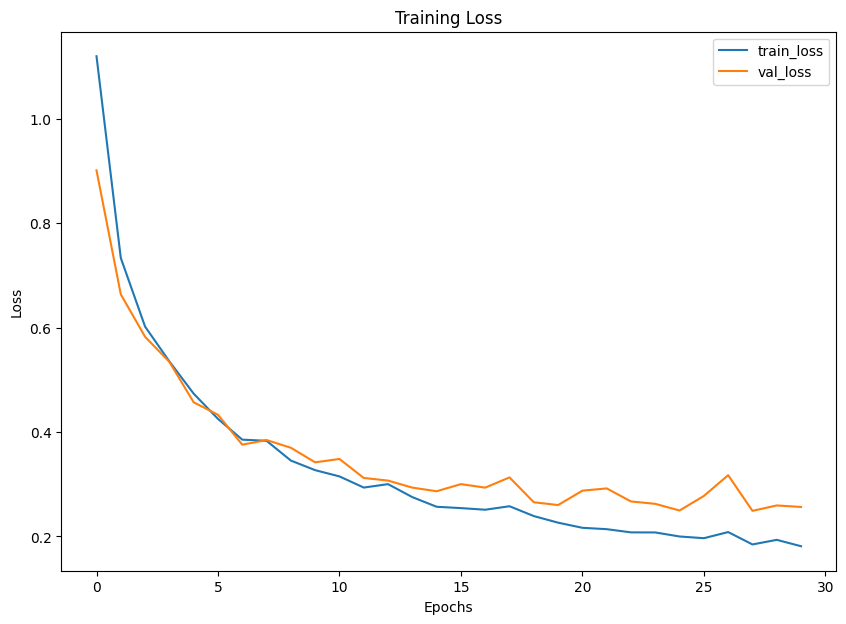

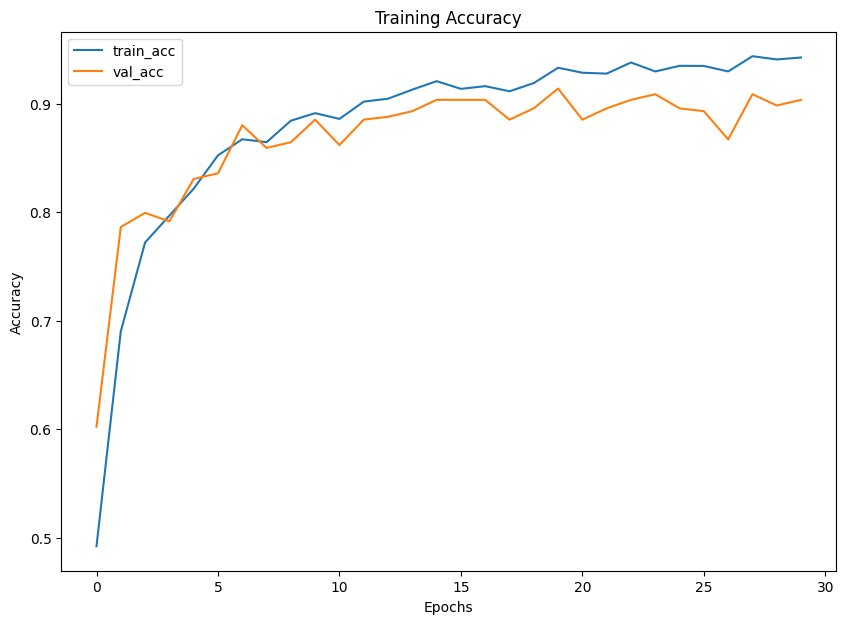

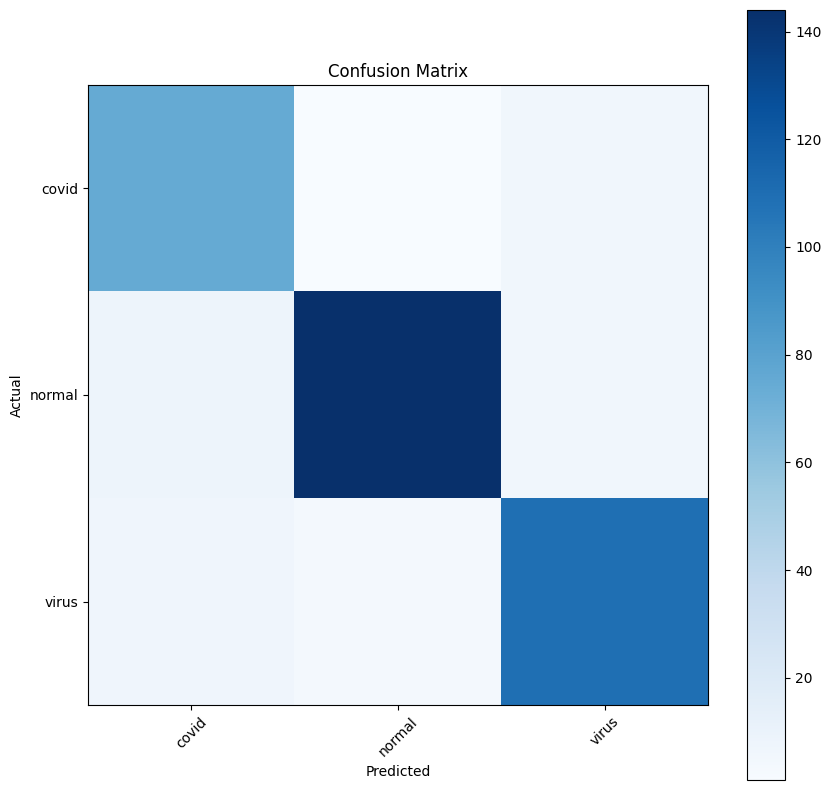

              precision    recall  f1-score   support

       covid       0.83      0.91      0.87        82
      normal       0.97      0.91      0.94       158
       virus       0.90      0.91      0.90       120

    accuracy                           0.91       360
   macro avg       0.90      0.91      0.90       360
weighted avg       0.91      0.91      0.91       360



In [82]:
## Avaliação do modelo

# Plot the training results
plt.figure(figsize=(10, 7))
plt.plot(cnn_results["train_loss"], label="train_loss")
plt.plot(cnn_results["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(cnn_results["train_acc"], label="train_acc")
plt.plot(cnn_results["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Get predictions and targets
all_preds, all_targets = predict(model=model,
                                 dataloader=test_loader,
                                 device=device)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.argmax(dim=1).cpu())

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(3), class_names, rotation=45)
plt.yticks(np.arange(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report
print(classification_report(all_targets.cpu(), all_preds.argmax(dim=1).cpu(), target_names=class_names))
